In [ ]:
#| hide
from nbdev import *

# LAMMPS Tutorial
> This example uses ASAP3/LAMMPS potential to calculate forces and energies. This is a free calculator which can be installed either from conda-forge or separately. At the moment conda-forge version supports only linux environment. You can run this tutorial on binder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/jochym%2Fhecss/devel?labpath=01_LAMMPS_Tutorial.ipynb).

HECSS sampler may be used in multiple ways. Three main modes are:

1. Jupyter notebook
2. (I)Python scripts
3. Command line programs included with the HECSS library. See the [CLI](cli.html) sction for more information.

Probably the easiest way to start is a notebook path presented here. You can quite easily convert your notebooks to more sophisticated python scripts by saving them as such from the JupyterLab file menu (File/Save and Export as/Executable script). The CLI route is also fairly simple, but limits the use of the library to pre-packaged procedures with limited configurability.

### Preamble
Every non-trivial python program starts with a series of `import` statements. Here, we import `HECSS` class from the main part of the library, `plot_stats` diagnostic plotting function from the `hecss.monitor` sub-module, two utility functions encapsulating the ASAP calculator use from the `hecss.util` sub-module and, finally, the `bulk` crystal builder from the `ase.build` library.

In [ ]:
#| asap
from hecss import HECSS
from hecss.monitor import plot_stats
from hecss.util import select_asap_model, create_asap_calculator
from ase.build import bulk

In [ ]:
#| hide
import hecss.optimize
from hecss.optimize import make_sampling

### Crystal building

To build the structure of the crystal we are using the `bulk` method from ASE and provide the information defining the crystal (cubic 3C SiC structure in our case):
* composition: 'SiC'
* type of structure: 'zincblende'
* size of the cell: a=4.38...
* variant of the unit cell: cubic (instead of primitive)
* size of the supercell: 3x3x3

In [ ]:
#| asap
sc = (3,3,3)
cryst = bulk('SiC', crystalstructure='zincblende',
             a=4.38120844, cubic=True).repeat(sc)

### Calculator setup

The next step requires defining of the calculator used for evaluating energies and forces in the system. In our case it will be ASAP3 calculator. The `hecss.util` module provides two functions which simplify use of this calculator:
* `select_asap_model`: automatically selects the model for the given composition (list of elements) 
* `create_asap_calculator`: creates calculator object
These are fairly thin wrappers around ASE functions intended as a starting point for the user which is not familiar with ASE library and the calculator setup.

Thus, we first select the type of the potential (`model`) and then assign the created calculator object to the `cryst` object.

In [ ]:
#| asap
model = select_asap_model('SiC')
cryst.set_calculator(create_asap_calculator(model))

### The HECSS sampler object

In the next step we create object of the `HECSS` class, which encapsulates all of the configuration space functionality. By default, you can provide just the crystal object and either the calculator object (if it can be re-used) or the calculator generation function.

In the case of ASAP calculator we need to provide a generator, since, due to the peculiarities of the ASAP implementation of the ASE calculator which cannot be re-used when the sampler is re-executed. This is achieved with the second parameter with the `lambda` anonymous function. This construct is probably not required for all calculators (e.g. for VASP we can use just calculator object).

The last parameter (`pbar`) specifies that we want to have progress bar indicating the progress of the calculation.

In [ ]:
#| asap
hecss = HECSS(cryst, lambda : create_asap_calculator(model), pbar=True)

### Prior distribution

The configuration space sampling starts with the generation of the prior energy distribution with the `HECSS.sampe` method. It generates a number (`N` here) of configurations with corresponding displacements, forces and energies targeted at some temperature (`T` here). The energy distribution of the sample is somewhat wider then the intended thermodynamic distribution described in the [Background](10_Background.html) section. Nevertheless, we expect the distribution to be fairly close to the target (orange, dashed line), and the plot provided by the `plot_stats` confirms our expectation.

  0%|          | 0/250 [00:00<?, ?it/s]

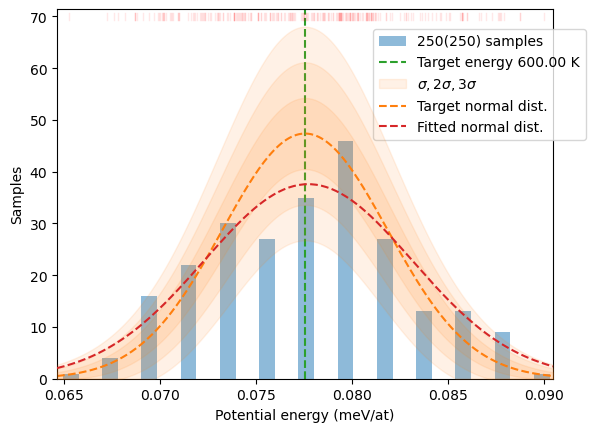

In [ ]:
#| asap
T = 600
N = 250
samples = hecss.sample(T,N)
plot_stats(samples, T)

### Thermodynamic distribution

The second step in the configuration space sampling is a proper re-shaping of the sample to give it normal average energy distribution expected in the thermodynamic equilibrium. This is achieved by creating proper weighting of the samples generated in the previous step. This weighting is realised with the `HECSS.generate` method which, in turn, encapsulates distribution shaper implemented in `make_sampling` function from the `hecss.optimize` sub-module. See [Optimize](optimize.html) section for implementation details.

The final sampling is generated for the target temperature (`T`) and should fall close to the expected thermal equilibrium distribution - as the diagnostic plot below confirms. 

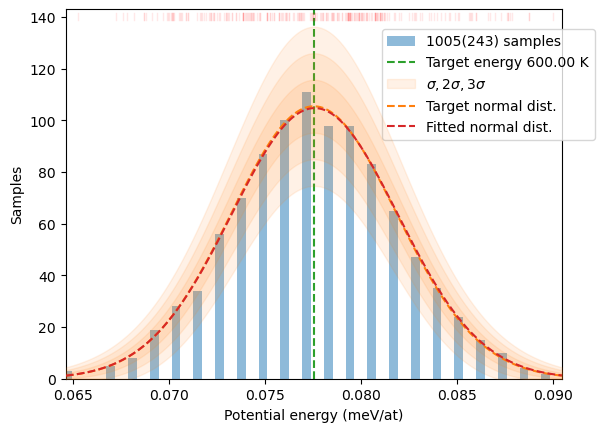

In [ ]:
#| asap
distrib = hecss.generate(samples, T)
plot_stats(distrib, T)

Alternatively, if the precise temperature is not important, you can generate distribution around actual mean energy - optimising the effectiveness of the sampling. 

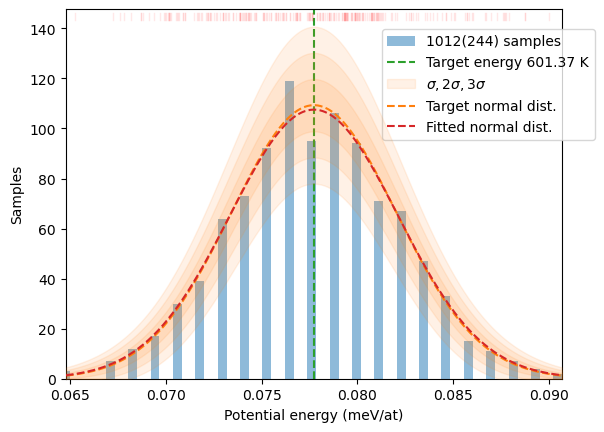

In [ ]:
#| asap
distrib = hecss.generate(samples)
plot_stats(distrib)